In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pickle import load, dump
from collections import Counter
from tqdm import tqdm

plt.style.use(f"{os.environ['style']}")

with open(r'D:\dstore\nlp\w2v\fwords', 'rt') as f:
    full_words = Counter({f'_{x[1]}_': int(x[0]) for x in [x.strip().split() for x in f.readlines()]})

ldct = {
    'alpha': {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'},
    'unifx': {'s_', 'd_', 'r_', 'n_', 't_', 'x_', 'y_', 'a_', 'i_', 'o_', '_a', '_o', '_e', '_i'},
    'unifx_l': {'s_', 'y_', '_a', '_e'},
    'fdbl': {'b', 'c', 'd', 'f', 'g', 'l', 'm', 'n', 'p', 'r', 's', 't'},
    'bdbl': {'b', 'd', 'g', 'm', 'l', 'n', 'p', 'r', 't'},
    'avwls': {'a', 'e', 'i', 'o', 'u', 'y'},
    'bvwls': {'a', 'e', 'i', 'o', 'u'},
    'cvwls': {'a', 'e', 'o', 'i', 'y'},
    'dvwls': {'a', 'e', 'o', 'u'},
    'fvwls': {'a', 'o', 'i', 'u'},
    'uafxs': {'logy_', 'ity_', 'try_', 'cy_', 's_', 'y_'}
}

def surrounds(afx, window=3, merge=False, exact=False):
    left_cnt, right_cnt = Counter(), Counter()
    if not exact:
        afx = afx.strip('_')
        targets = [x.strip('_').split(afx) for x in full_words if afx in x]
    else:
        targets = [x.split(afx) for x in full_words if afx in x]
        targets = [(x[0].strip('_'), x[1].strip('_')) for x in targets]

    if not exact or (exact and afx[-1] == '_'):
        for x in targets:
            fln = min(len(x[0]), window)
            if fln: left_cnt[x[0][-fln:]] += 1
    if not exact or (exact and afx[0] == '_'):
        for x in targets:
            fln = min(len(x[1]), window)
            if fln: right_cnt[x[1][:fln]] += 1

    if merge or exact:
        for x in left_cnt: right_cnt[x] += left_cnt[x]
        return right_cnt
    else:
        return left_cnt, right_cnt

def kld(P, Q=None, dist='base'):
    pcnt = Counter({x: 3 for x in ldct['alpha']})
    for x in P:
        for y in x: pcnt[y] += P[x]  
    psum = sum(x for x in pcnt.values())
    if Q:
        qcnt = Counter({x: 3 for x in ldct['alpha']})
        for x in Q:
            for y in x: qcnt[y] += Q[x]
        for x in ldct['alpha']:
            if pcnt[x] == 3 and qcnt[x] == 3:
                pcnt.pop(x)
                qcnt.pop(x)
        qsum = sum(x for x in qcnt.values())
        return sum([(pcnt[x] / psum) * np.log2((pcnt[x] / psum) / (qcnt[x] / qsum)) for x in pcnt])
    else:
        if dist == 'base': d = ndst
        elif dist == 'pre': d = pdst
        elif dist == 'suf': d = sdst
        return sum([(pcnt[x] / psum) * np.log2((pcnt[x] / psum) / d[x]) for x in pcnt])

def pulld(afx, len_lim=False):
    aln = len(afx)
    sub_set = [x for x in tf2 if afx in x]
    out = []
    for x in sub_set:
        i = 1
        if x[0] == '_':
            while len(x[:-i]) > aln:
                if x[:-i] in sub_set:
                    break
                i += 1
            else: out.append(x)
        else:
            while len(x[i:]) > aln:
                if x[i:] in sub_set:
                    break
                i += 1
            else: out.append(x)
    if len_lim: return [x for x in out if x != afx]
    else: return [x for x in out if len(x) == len(afx)+1 and x != afx]

def pullu(afx):
    i = 1
    if afx[0] == '_':
        while i < len(afx):
            if afx[:-i] in tf2:
                return afx[:-i]
            i += 1
    else:
        while i < len(afx):
            if afx[i:] in tf2:
                return afx[i:]
            i += 1


with open(r'D:\dstore\tmp\4', 'rb') as f:
    ndst, pdst, sdst = load(f)
with open(r'D:\dstore\tmp\7', 'rb') as f:
    tf2, rntp, drntp = load(f)
with open(r'D:\dstore\tmp\8', 'rb') as f:
    frel, brel, dfrel, dbrel = load(f)


" with open(r'D:\\dstore\tmp\x04', 'rb') as f:\n    ndst, pdst, sdst = load(f)\n\nwith open(r'D:\\dstore\tmp\x07', 'rb') as f:\n    tf2, rntp = load(f) "

In [2]:
for x in [x for x in full_words if len(x) < 5]:
    full_words.pop(x)

for x in [x for x in full_words if "'" in x]:
    out = x.split("'")
    if f'{out[0]}_' in full_words:
        full_words[f'{out[0]}_'] += full_words[x]
    full_words.pop(x)

smalls = {x for x in full_words if len(x) > 4 and len(x) < 12}
bigs = {x for x in full_words if len(x) > 7}

tf2 = Counter()
for x in tqdm(smalls):
    x = x.strip('_')
    group = [y for y in bigs if x in y]
    for y in group:
        out = y.split(x)
        if len(out) > 2:
            out.append(f'_{out[1]}')
            out.append(f'{out[1]}_')
            out.pop(1)
        for z in out:
            if z not in ('_', ''):
                tf2[z] += 1
tf2 = Counter({x[0]: x[1] for x in tf2.most_common() if x[1] > 2})

pdst, sdst, ndst = Counter(), Counter(), Counter()
for x in full_words:
    x = x.strip('_')
    for l in x: ndst[l] += 1
    i = round((len(x)+0.1) / 2)
    for l in x[:i]: pdst[l] += 1
    for l in x[-i:]: sdst[l] += 1
pdst = Counter({x[0]: x[1] / pdst.total() for x in pdst.most_common()})
sdst = Counter({x[0]: x[1] / sdst.total() for x in sdst.most_common()})
ndst = Counter({x[0]: x[1] / ndst.total() for x in ndst.most_common()})

rntp = {}
for x in tqdm(tf2):
    hold = []
    for i in range(1, 4):
        o1, o2 = surrounds(x, i)
        if x[0] == '_':
            hold.append([kld(surrounds(x, i, merge=True)), kld(o2, dist='pre'), kld(surrounds(x, i, exact=True), dist='pre')])
        else:
            hold.append([kld(surrounds(x, i, merge=True)), kld(o1, dist='suf'), kld(surrounds(x, i, exact=True), dist='suf')])
    rntp[x] = np.array(hold[::-1]).T

hold = []
for i in range(1, 4):
    frel, brel = Counter(), Counter()
    for x in full_words:
        if len(x) > 3+i:
            x = x.strip('_')
            for l in x[-i:]: brel[l] += 1
            for l in x[:i]: frel[l] += 1
    hold.append([kld(frel, dist='pre'), kld(brel, dist='suf')])
hold = [[x]*3 for x in np.array(hold[::-1]).T]
frel, brel = np.array(hold[0]), np.array(hold[1])

drntp = {}
for x in tqdm(tf2):
    above, below = pulld(x, True), pullu(x)
    if above: above = np.array([rntp[y] for y in above]).mean(axis=0)
    elif x[0] == '_': above = brel
    else: above = frel
    if below: below = rntp[below]
    elif x[0] == '_': below = frel
    else: below = brel
    middle = rntp[x]
    drntp[x] = (above-middle) - (middle-below)

ends = [(y, drntp[y]) for y in [x for x in tf2 if all(x not in y for y in tf2 if y != x)]]
dfrel, dbrel = np.array([x[1] for x in ends if x[0][0] == '_']).mean(axis=0), np.array([x[1] for x in ends if x[0][-1] == '_']).mean(axis=0)


100%|██████████| 31857/31857 [19:10<00:00, 27.70it/s]


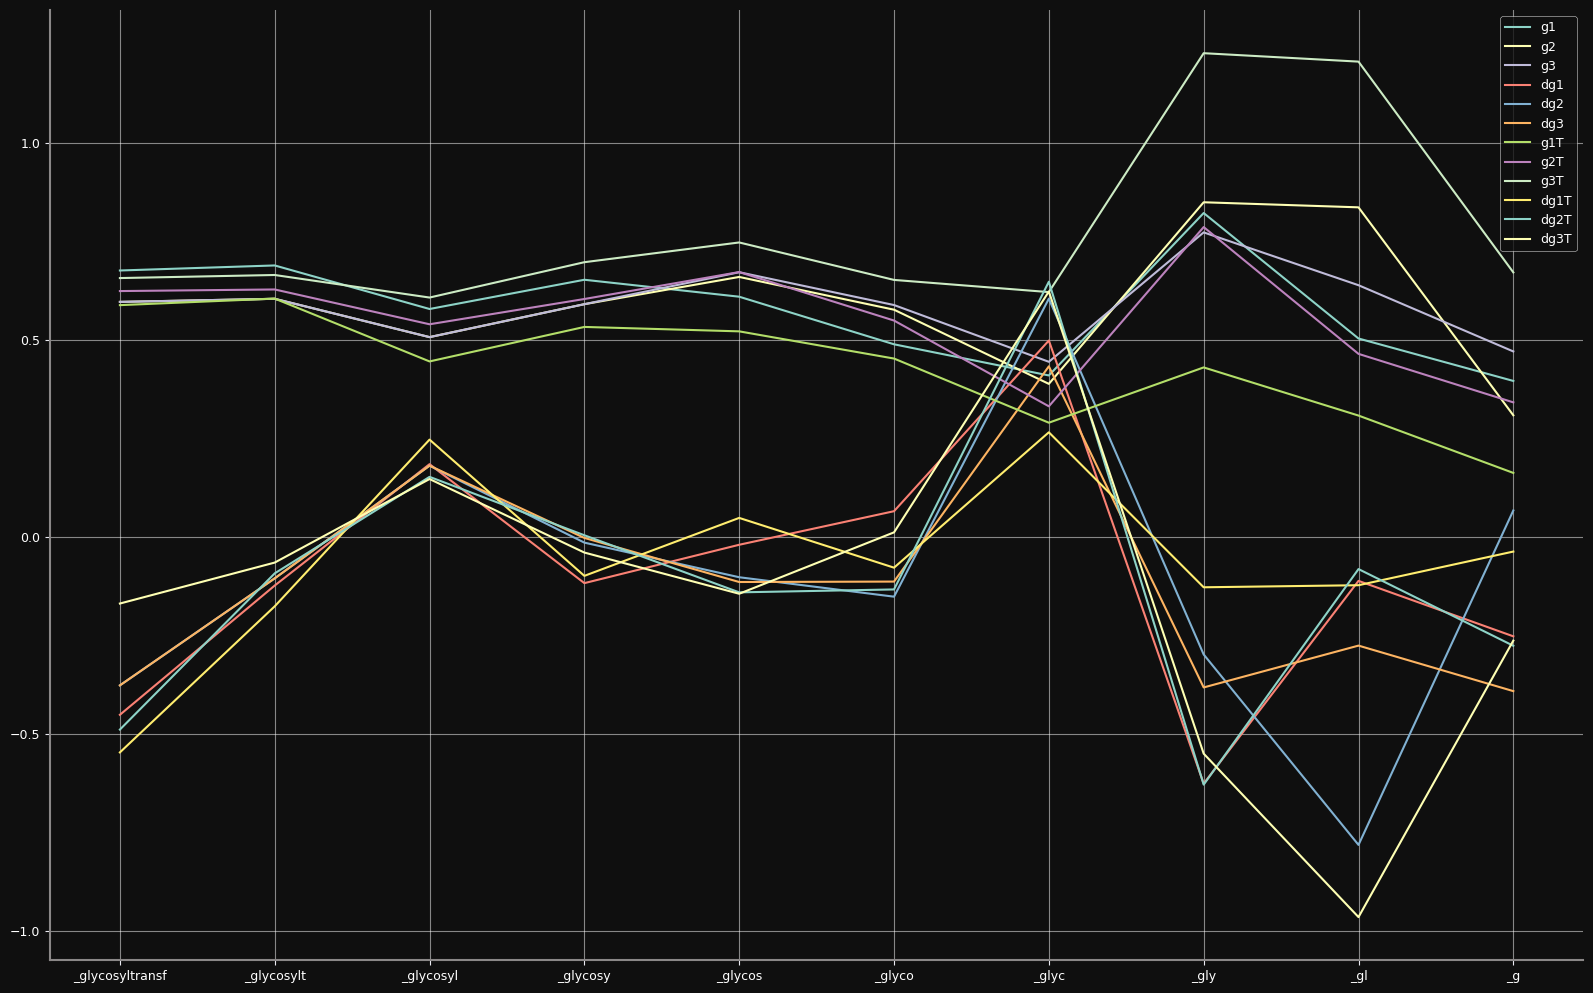

In [34]:
afx = '_glycosyltransf'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[*[np.mean(x) for x in rntp[x]], *[np.mean(x) for x in drntp[x]], *[np.mean(x) for x in rntp[x].T], *[np.mean(x) for x in drntp[x].T]] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'dg1', 'dg2', 'dg3', 'g1T', 'g2T', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

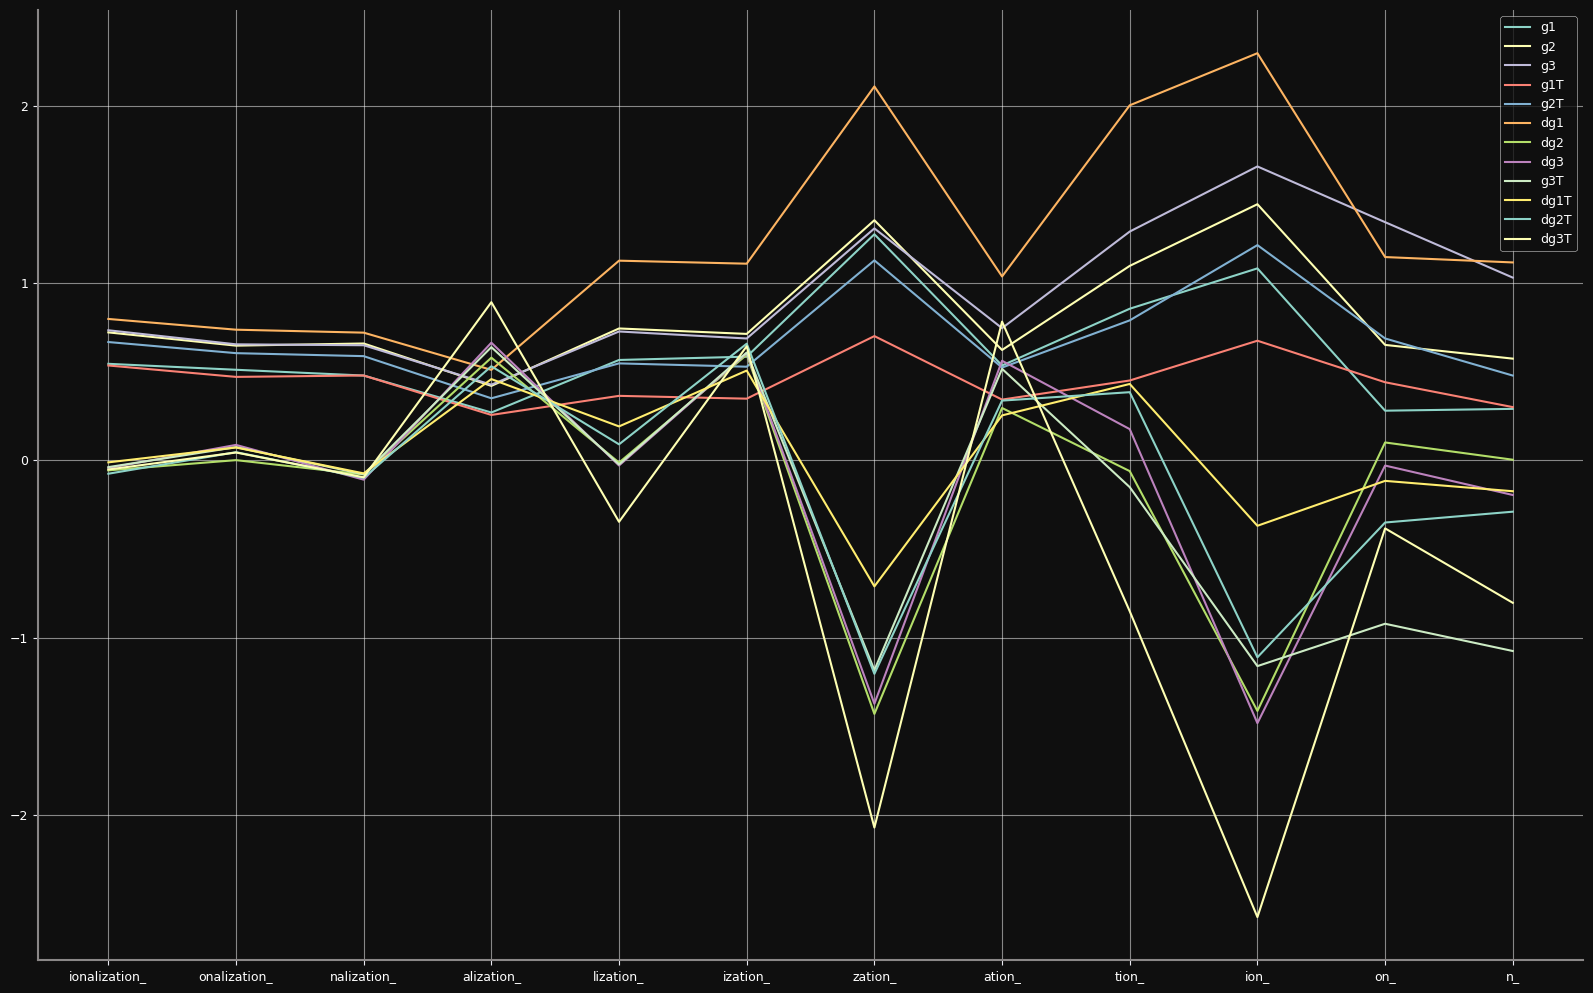

In [43]:
afx = 'ionalization_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

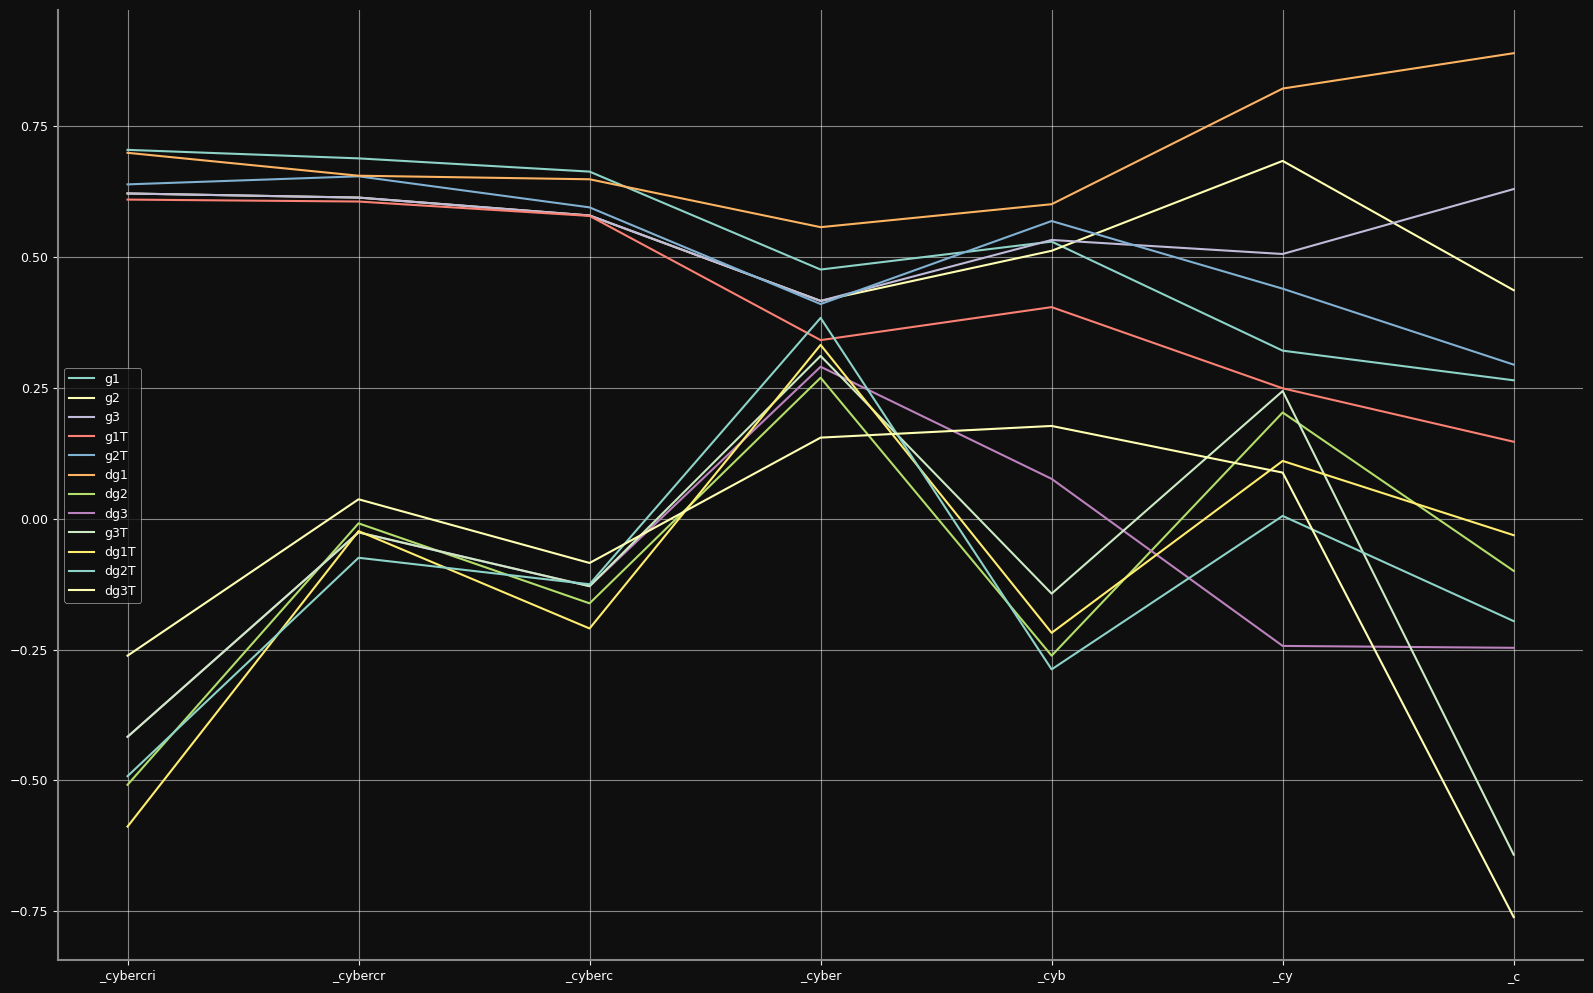

In [44]:

afx = '_cybercri'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

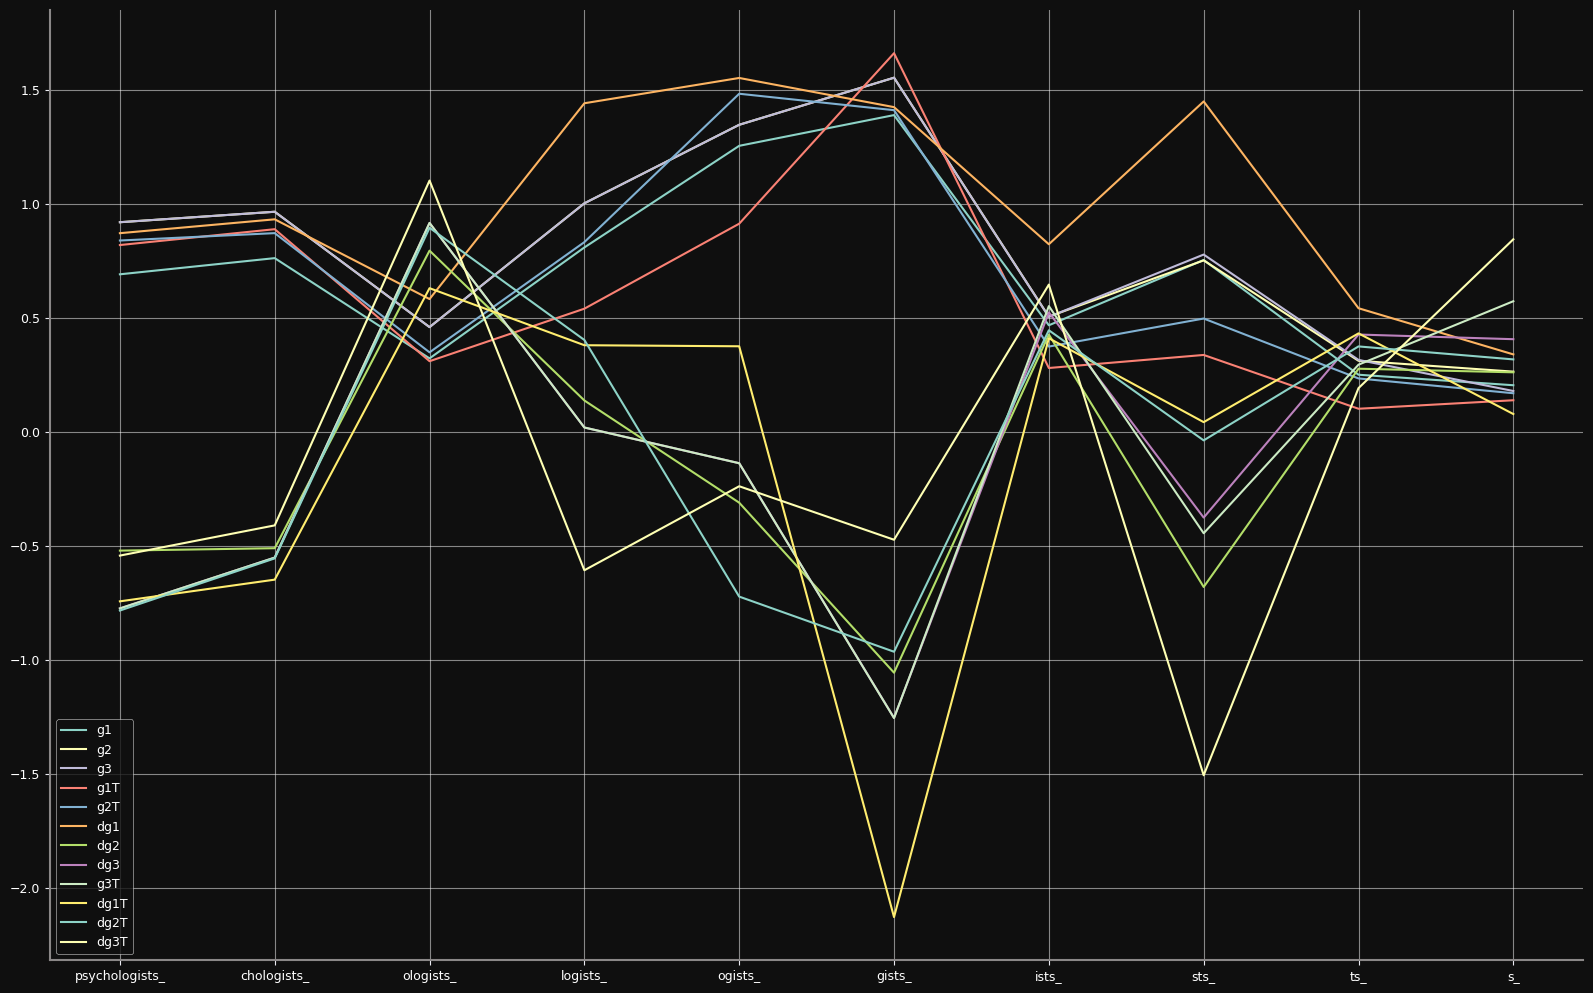

In [45]:

afx = 'psychologists_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

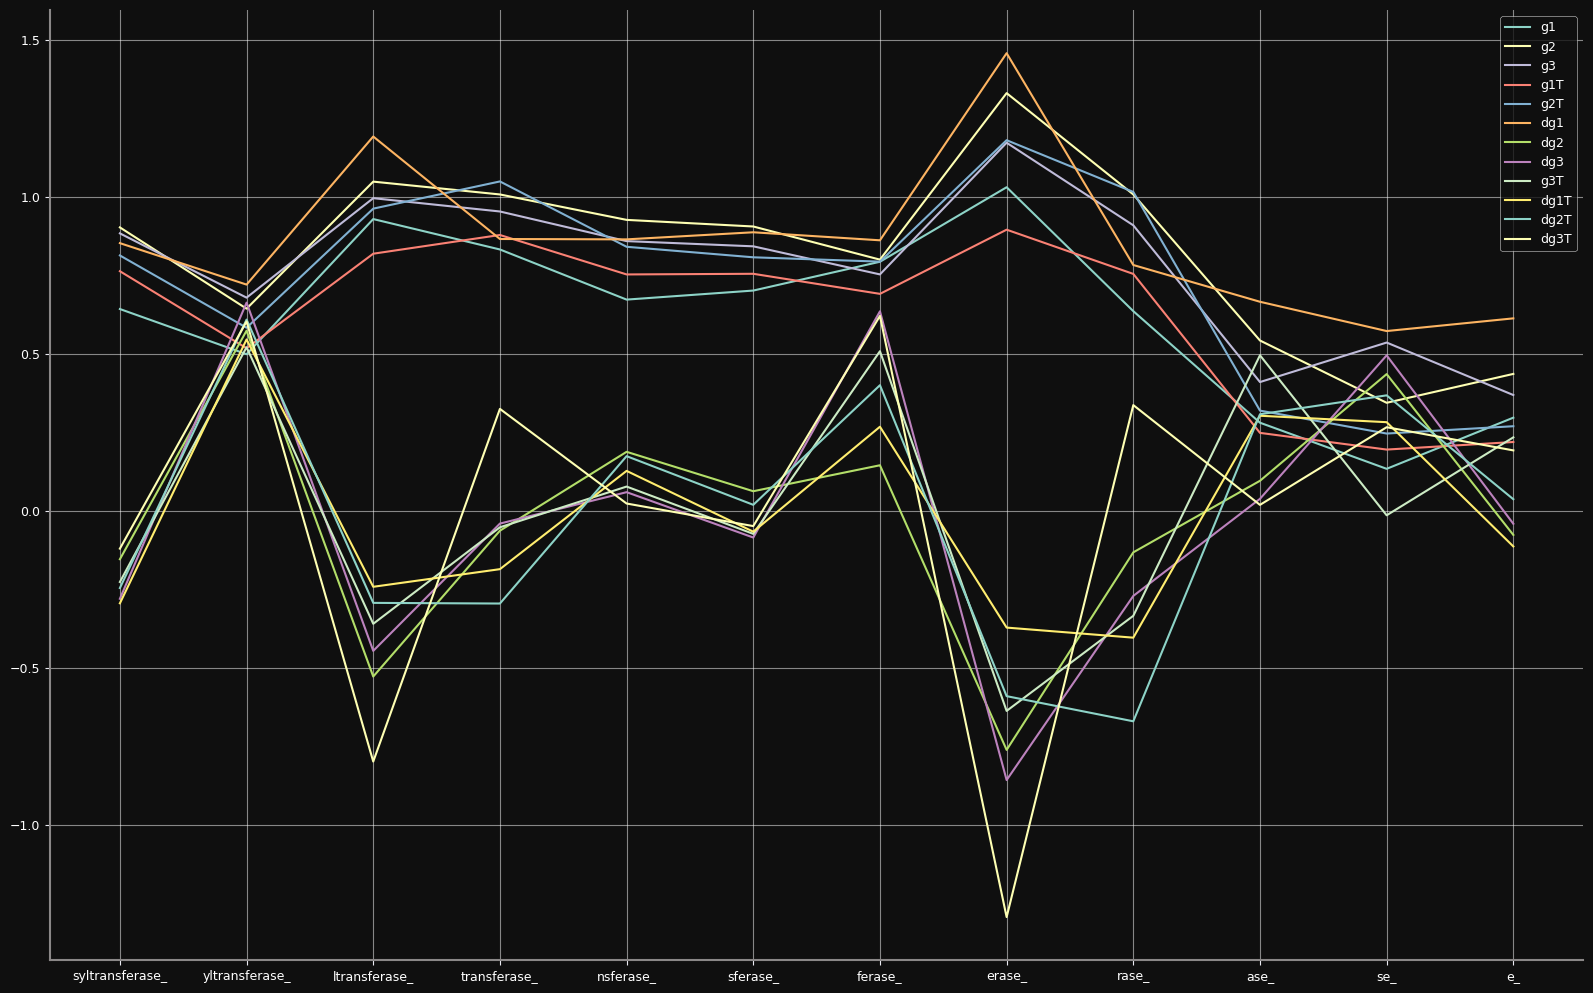

In [46]:
afx = 'syltransferase_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

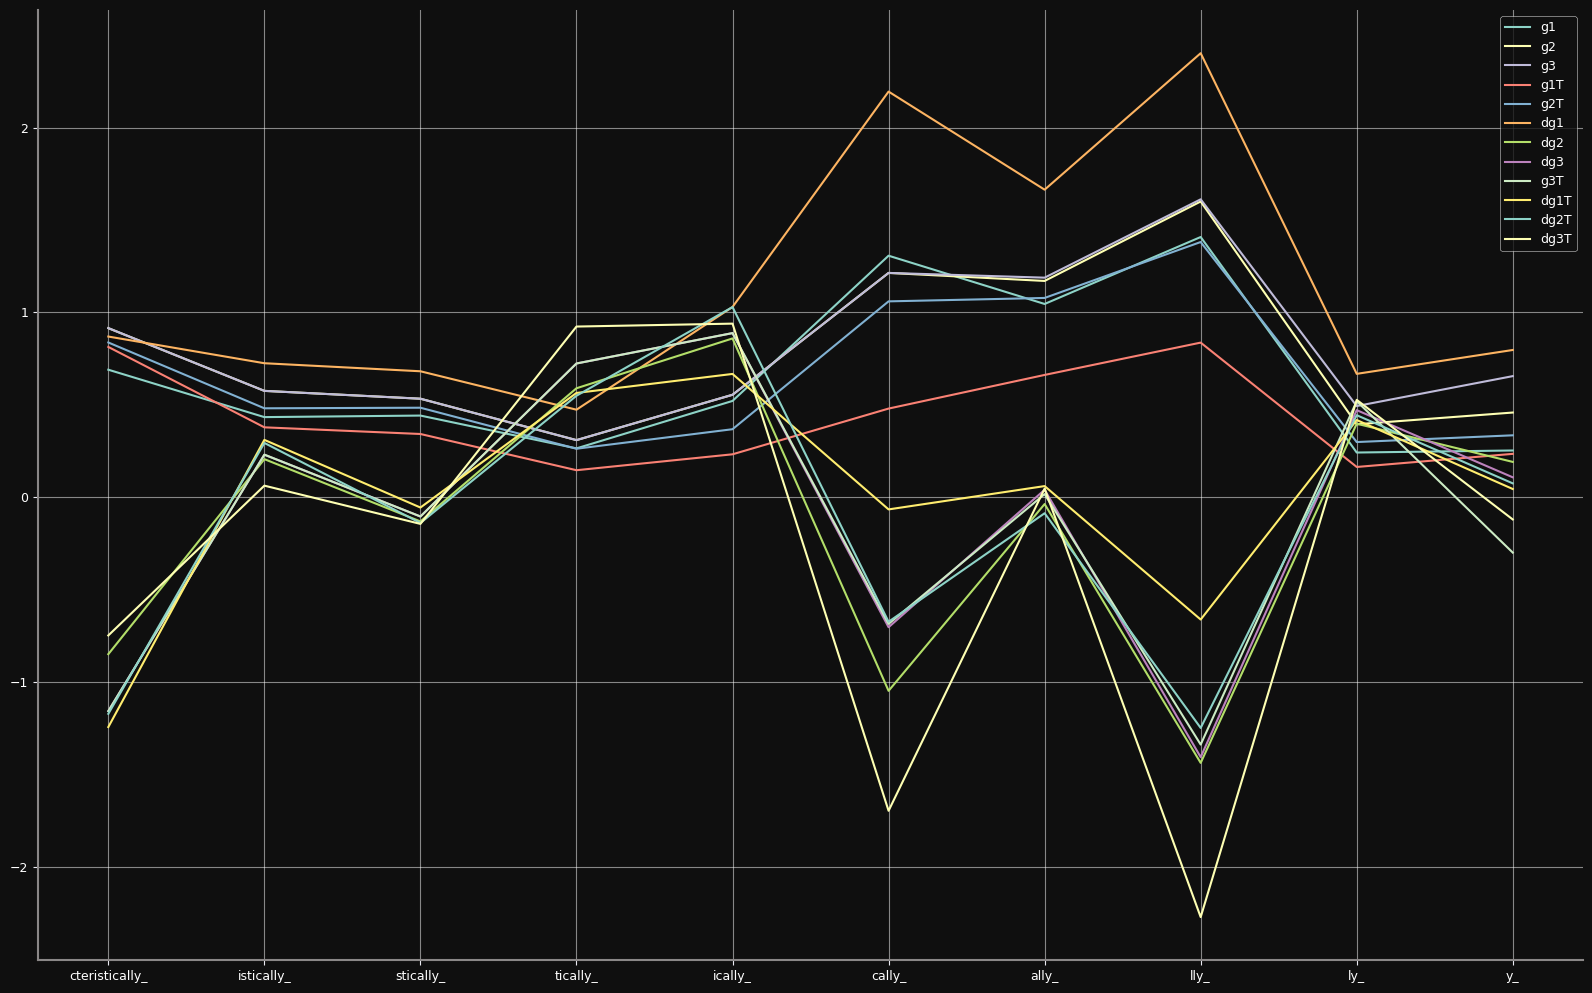

In [47]:

afx = 'cteristically_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

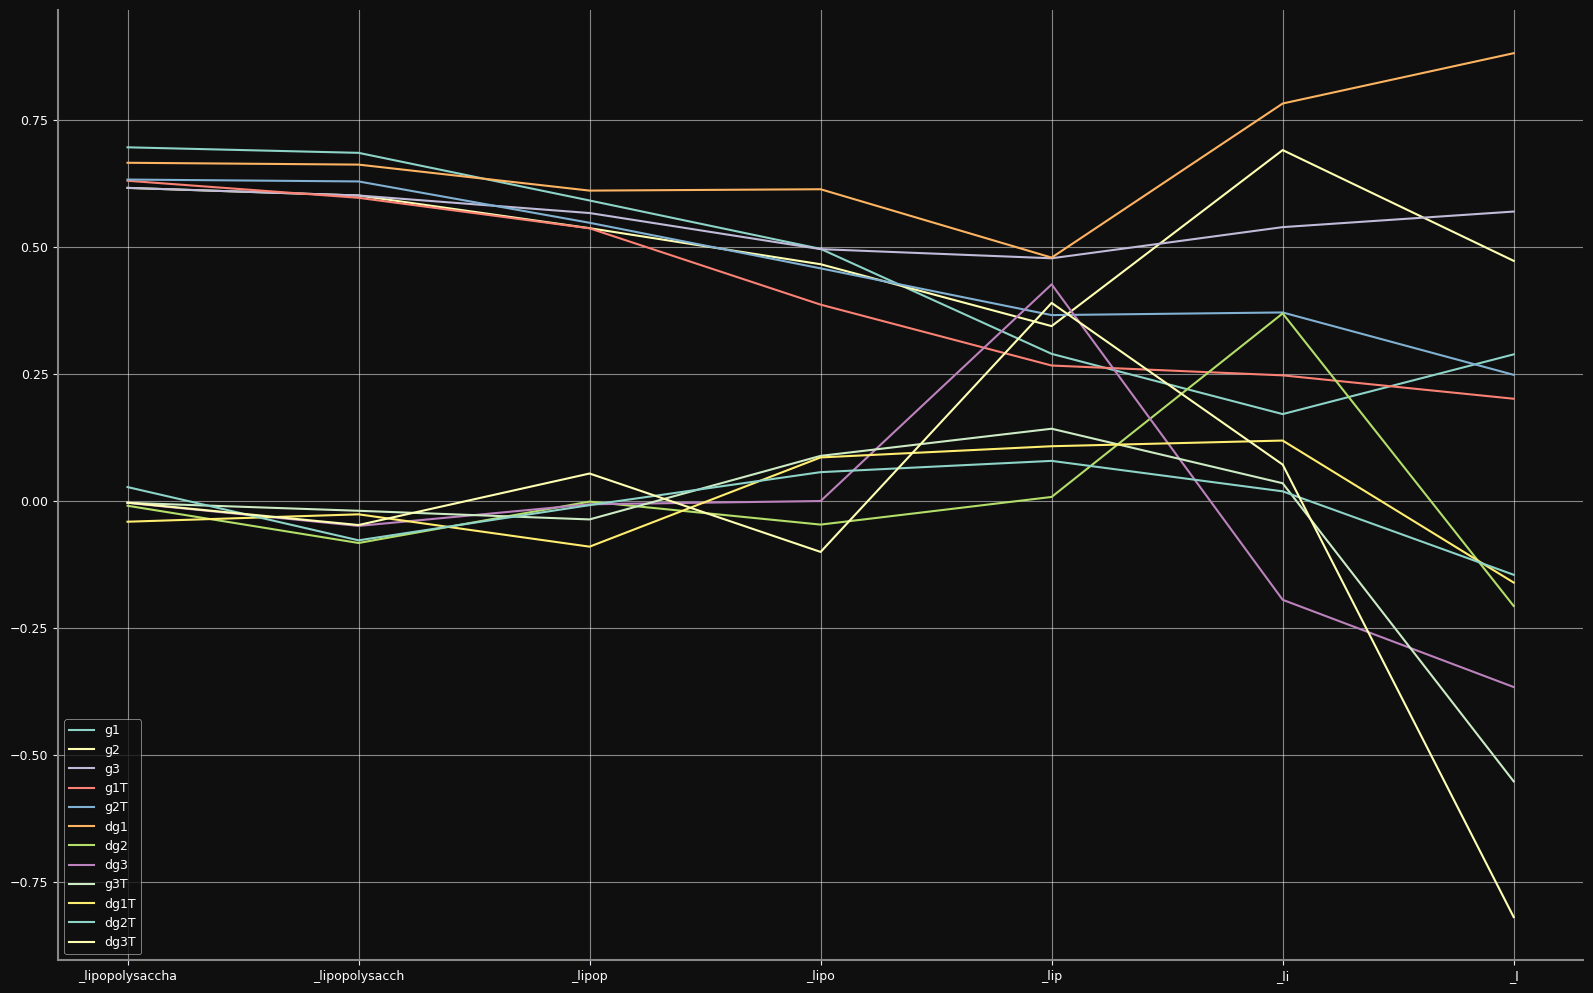

In [48]:

afx = '_lipopolysaccha'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

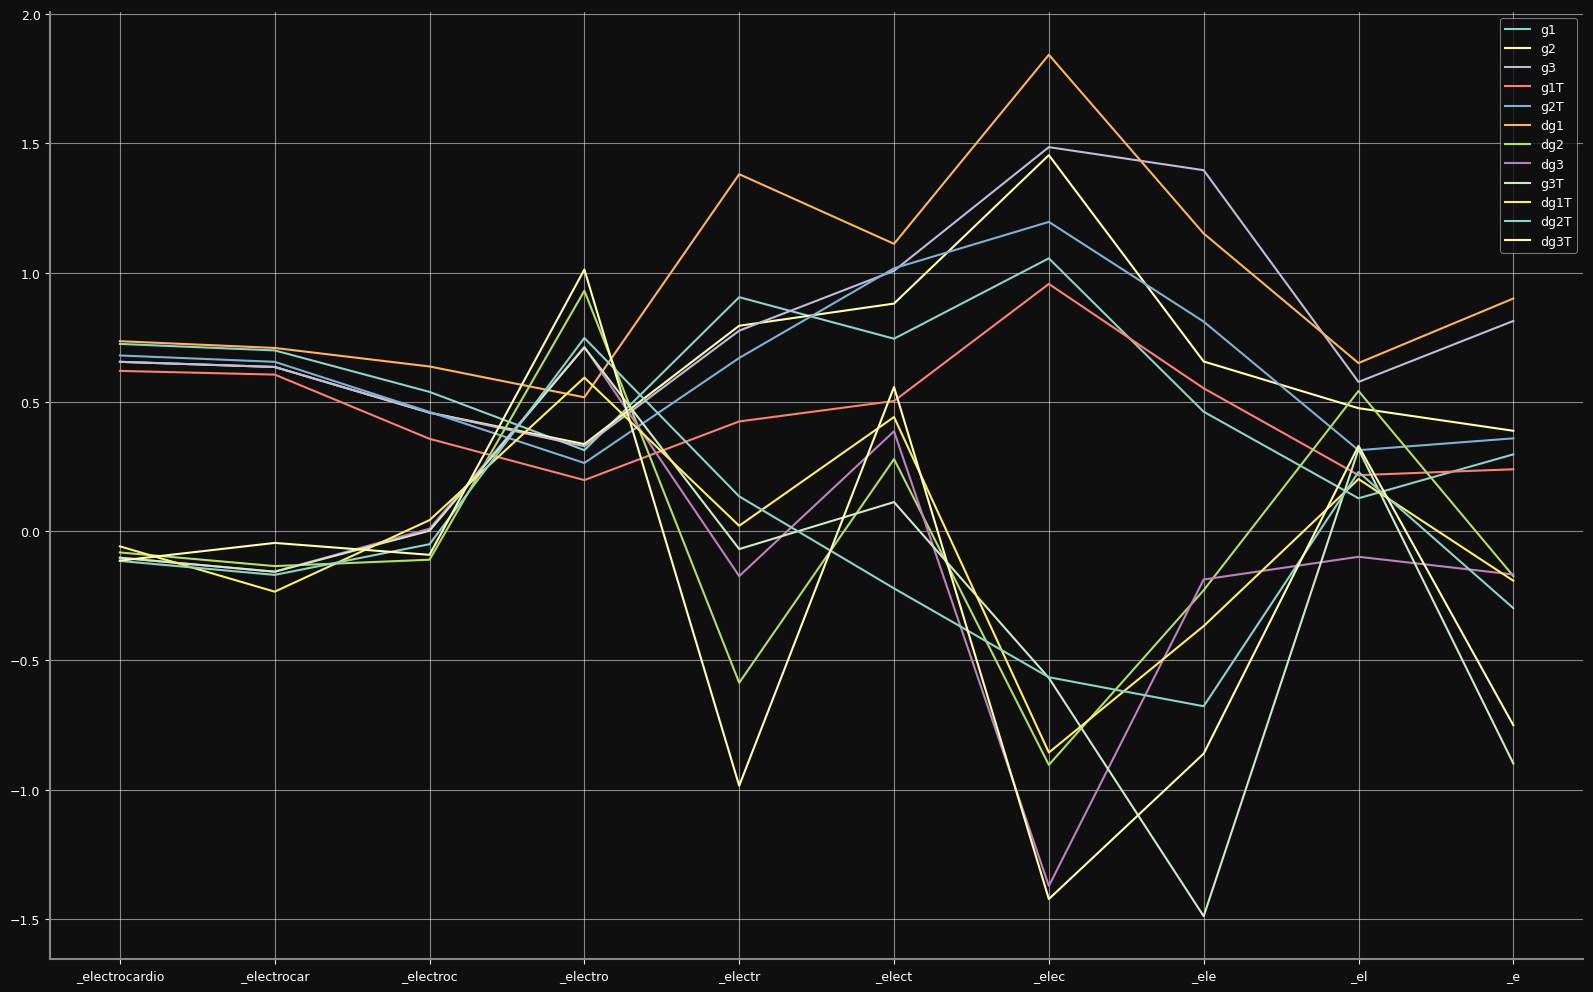

In [49]:
afx = '_electrocardio'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

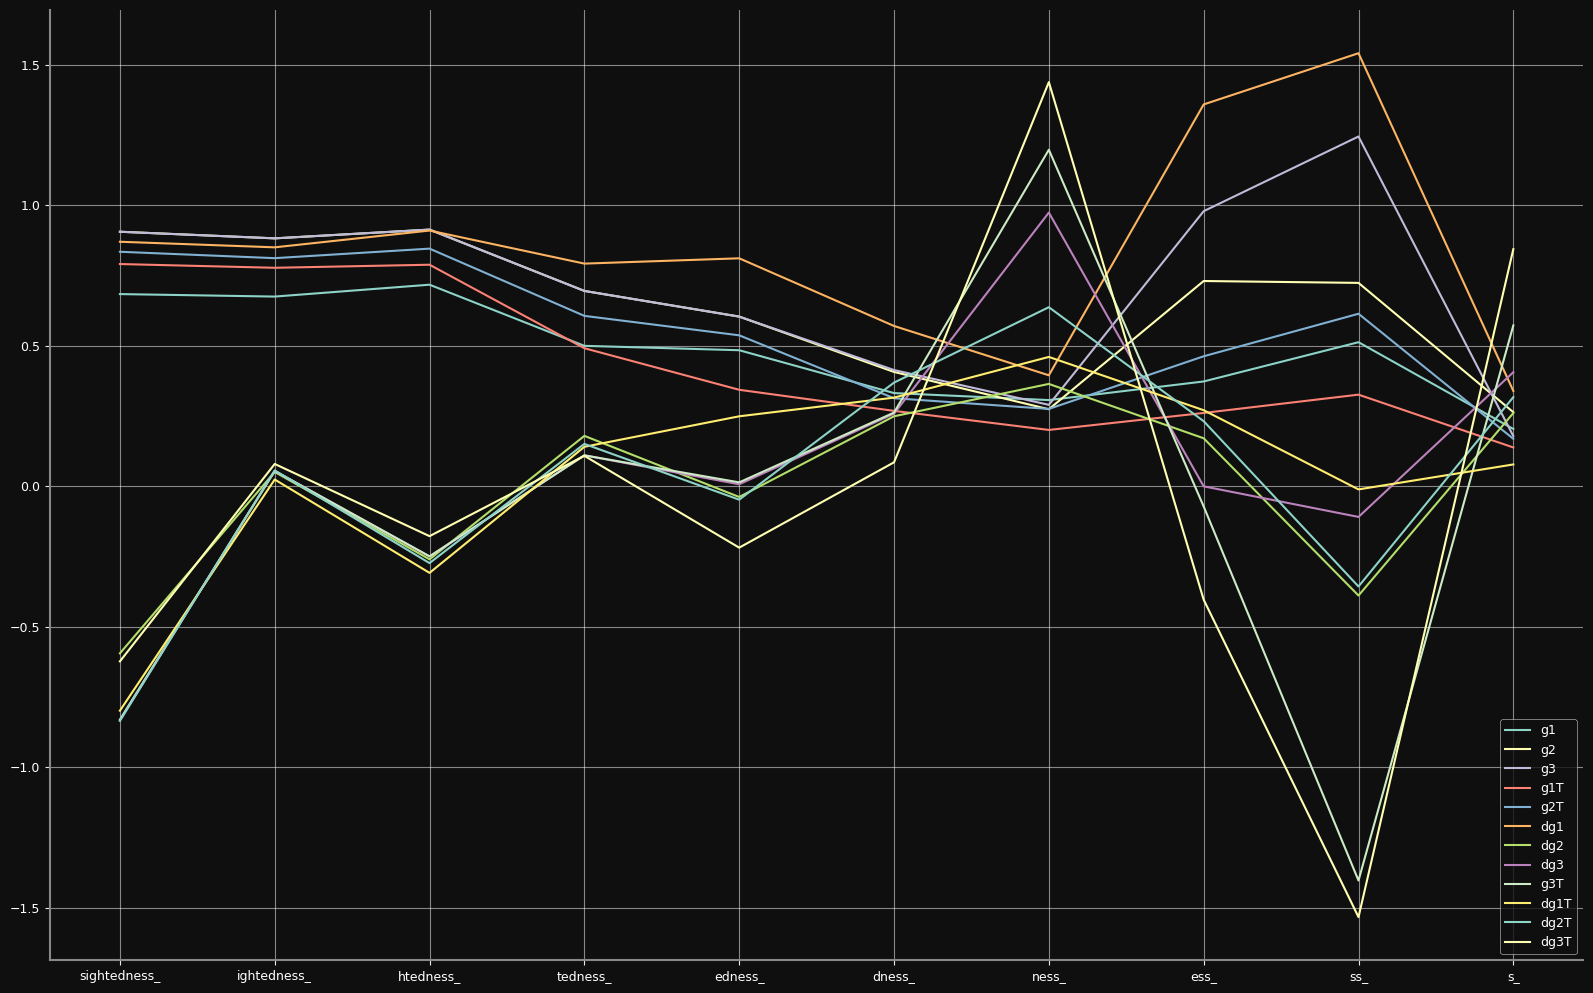

In [50]:
afx = 'sightedness_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

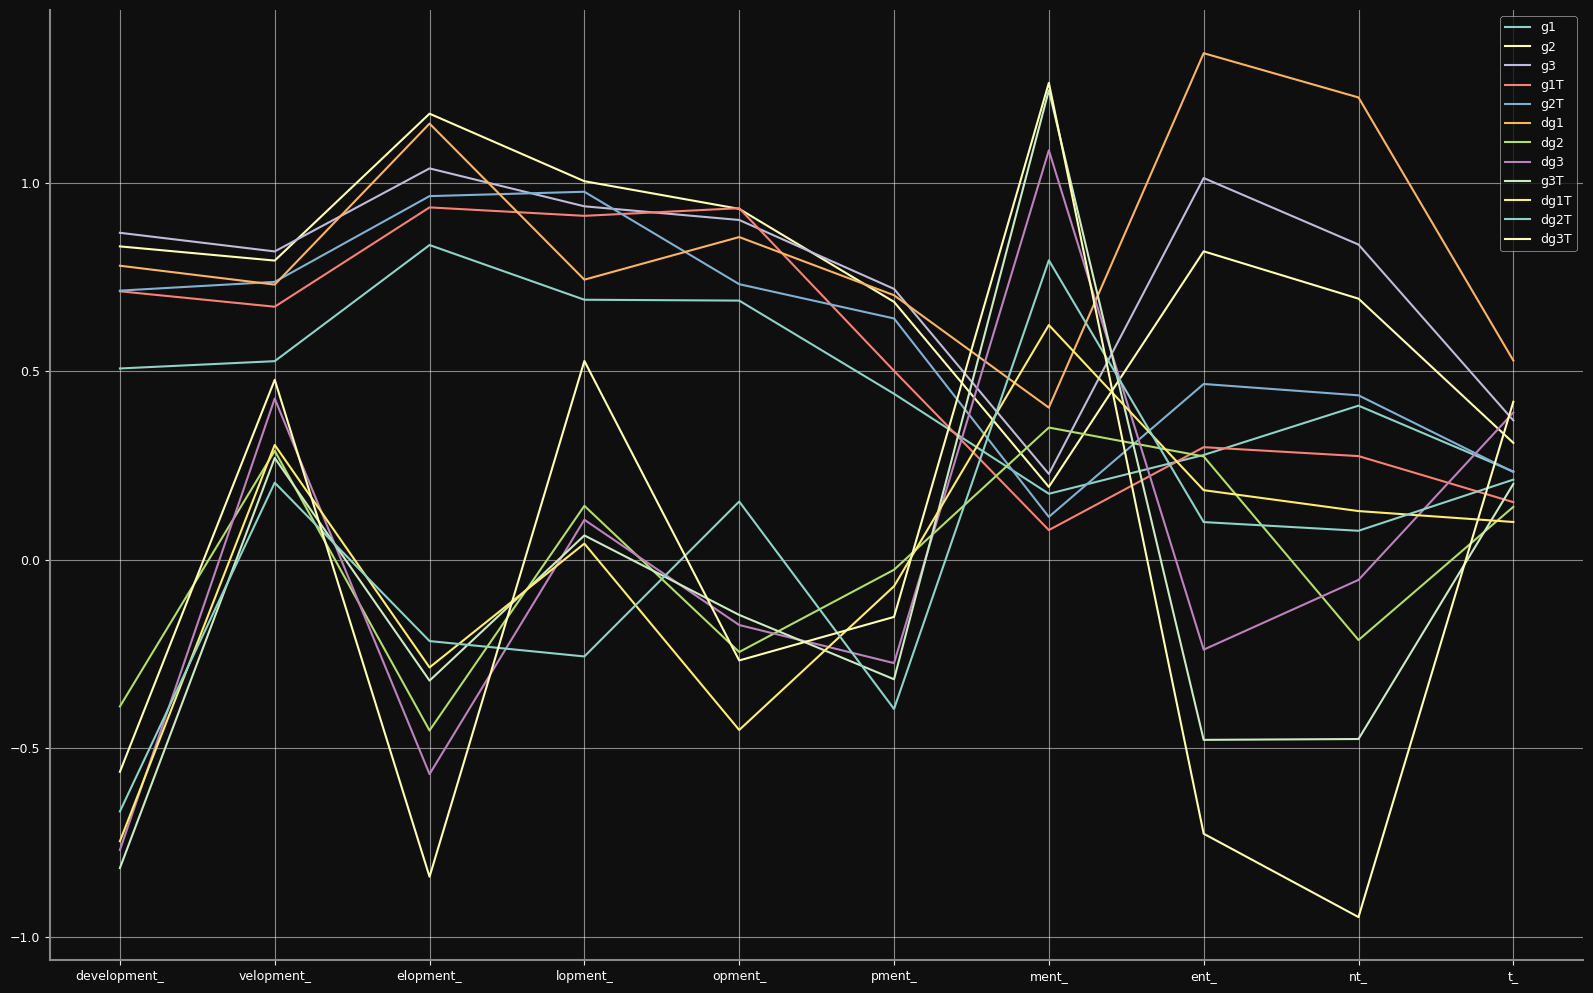

In [51]:
afx = 'development_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

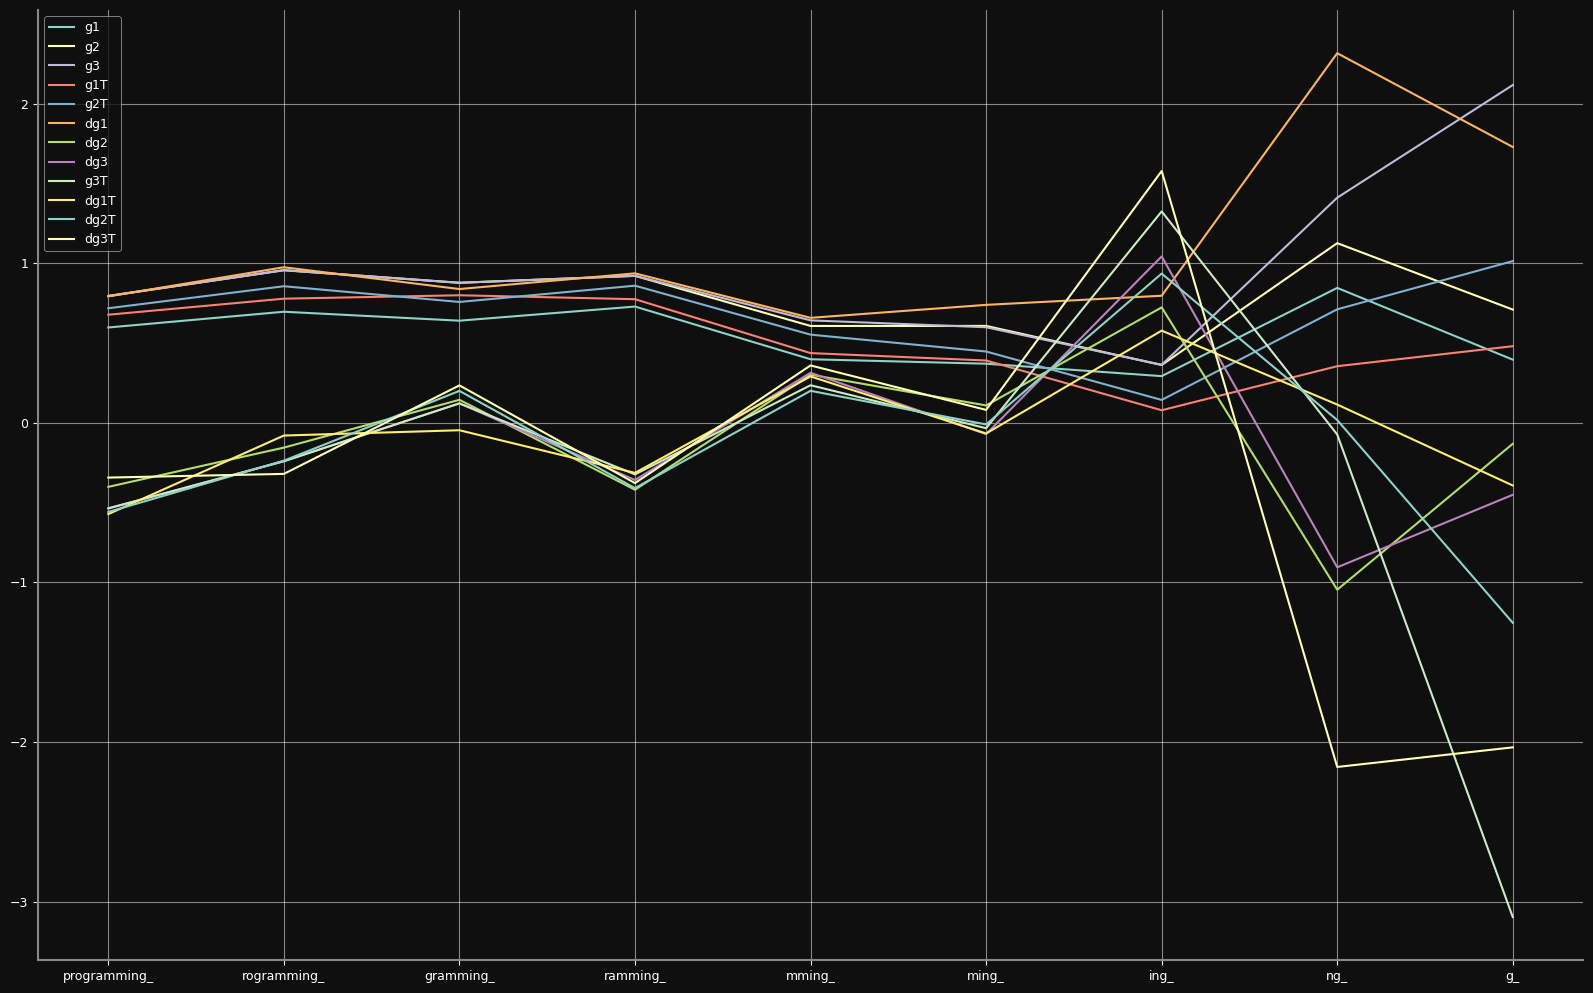

In [52]:
afx = 'programming_'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

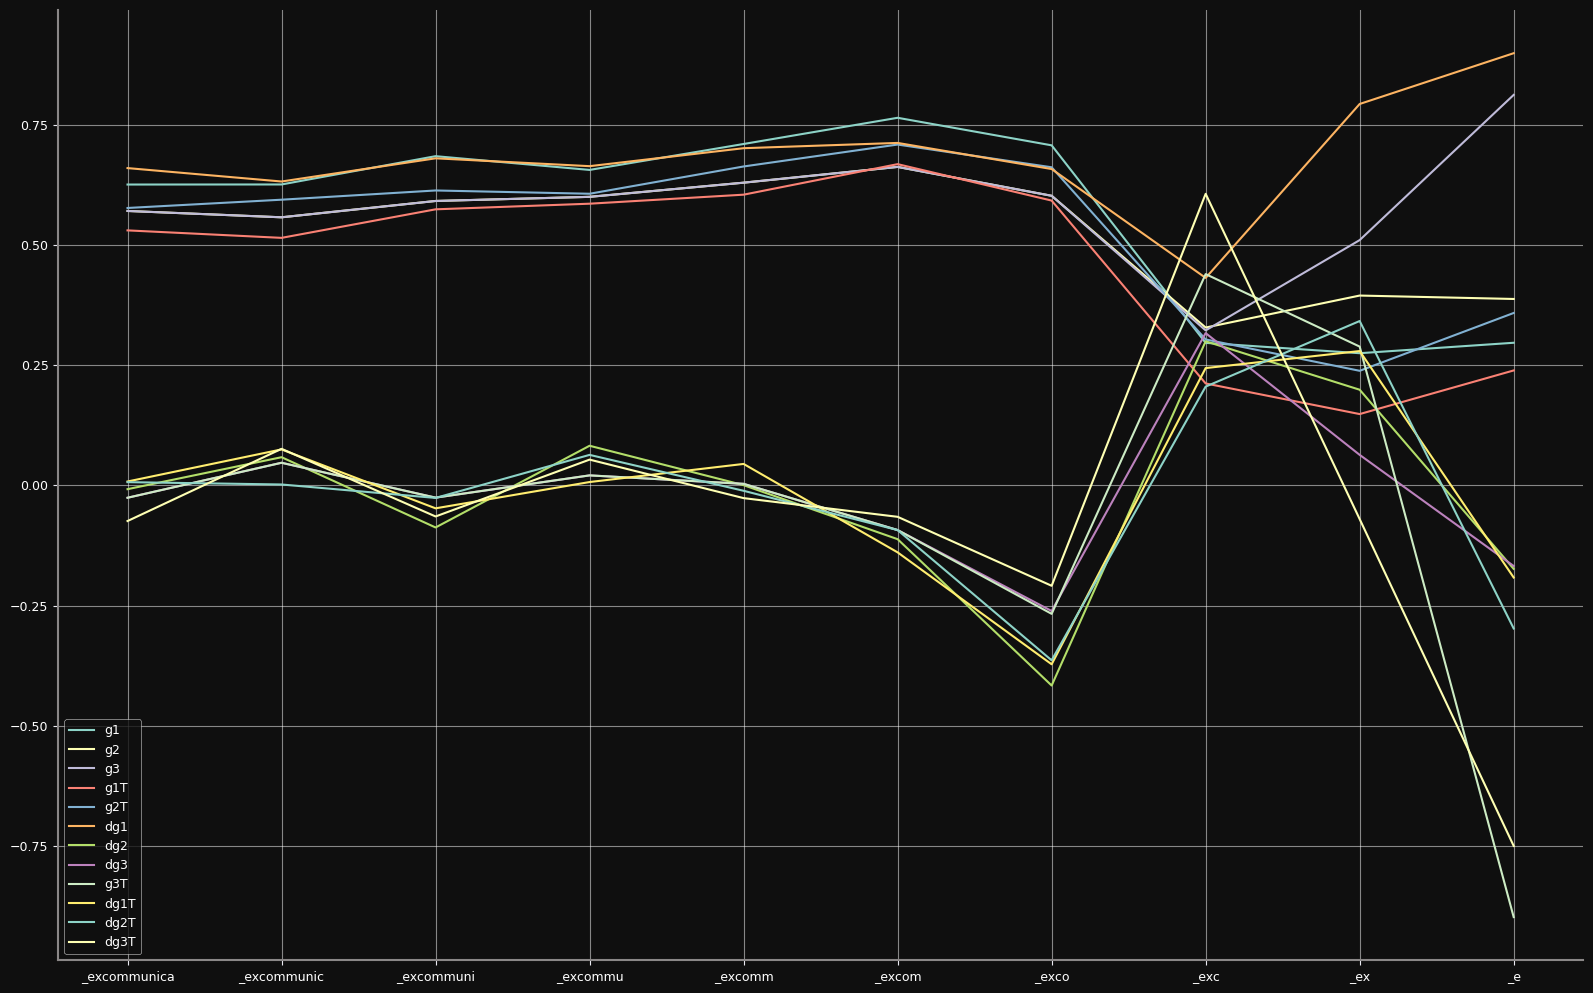

In [53]:
afx = '_excommunica'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

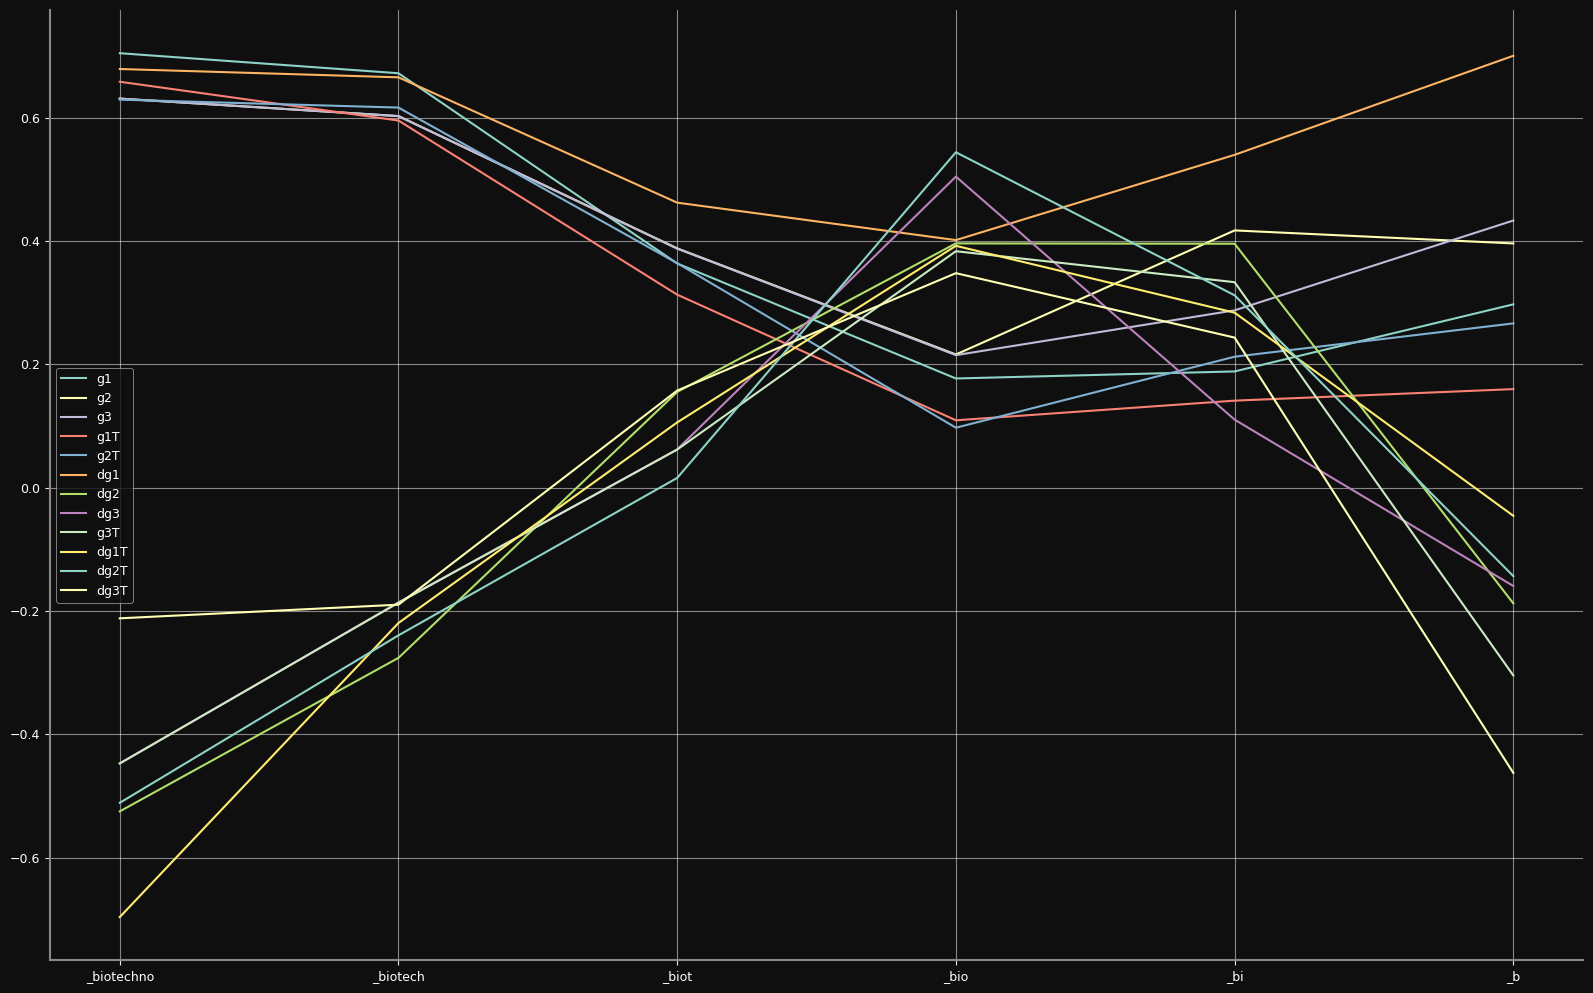

In [54]:
afx = '_biotechno'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])

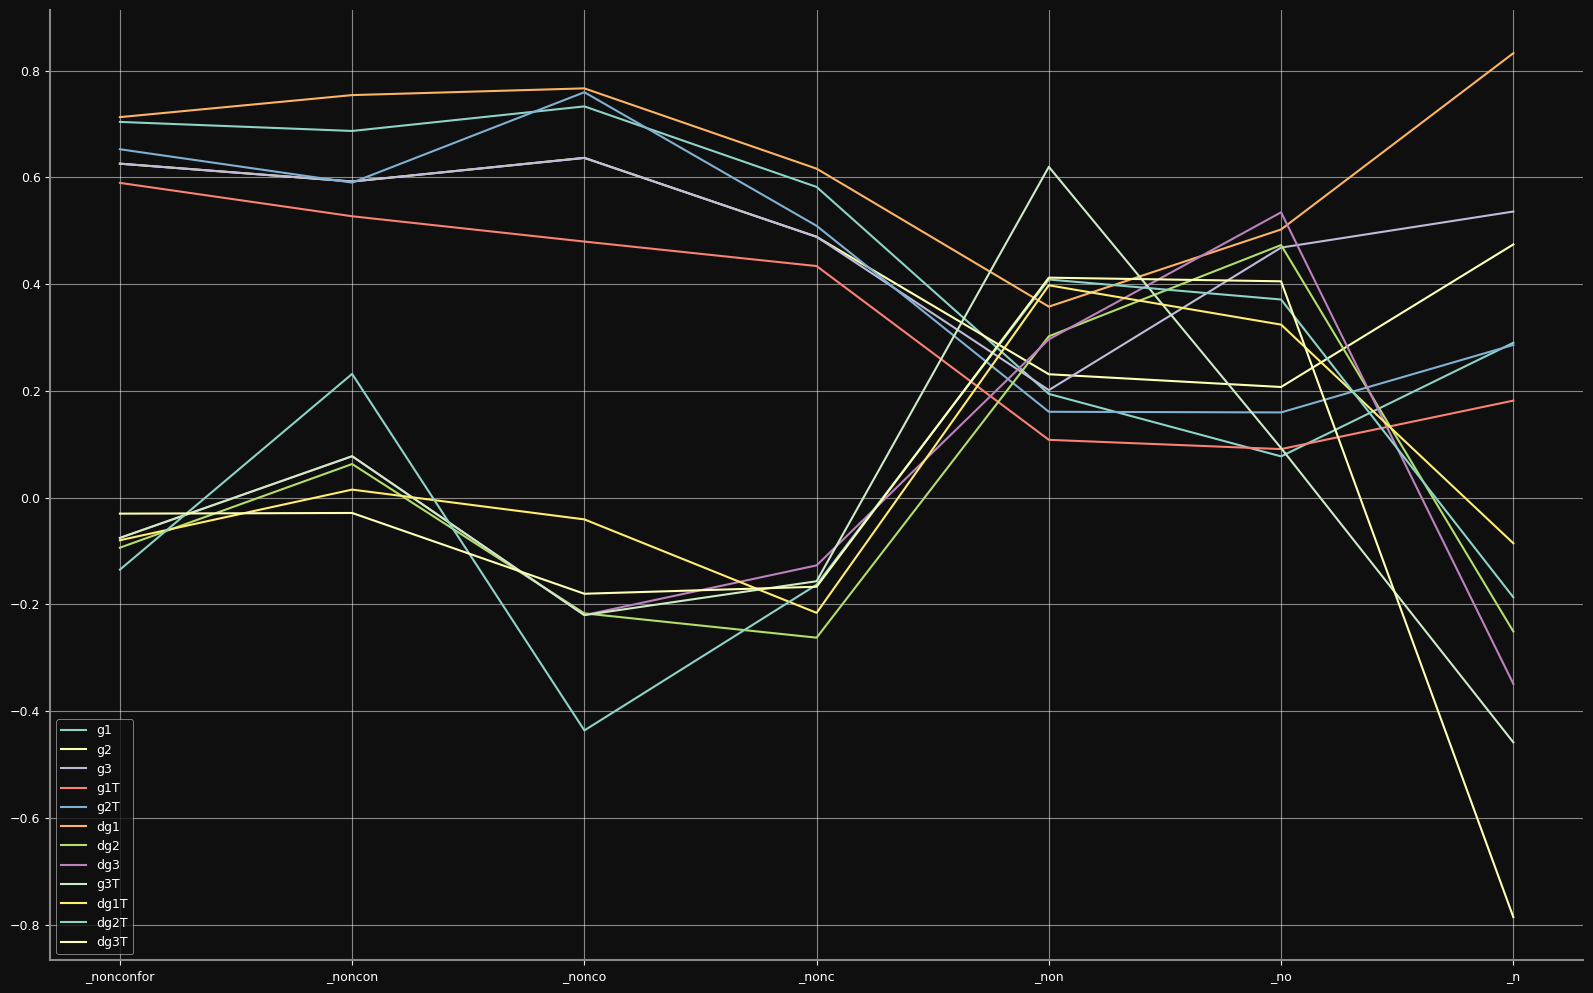

In [55]:
afx = '_nonconfor'
words = sorted([x for x in tf2 if x in afx], key=lambda x: len(x), reverse=True)
fig, ax = plt.subplots(figsize=(16, 10))
yvars = [[
    *[np.mean(x) for x in rntp[x]], 
    *[np.mean(x) for x in rntp[x].T], 
    *[np.mean(x) for x in drntp[x]], 
    *[np.mean(x) for x in drntp[x].T]
    ] for x in words]

plt.xticks(range(len(yvars)), words)
ax.plot(range(len(yvars)), yvars)
ax.legend(['g1', 'g2', 'g3', 'g1T', 'g2T', 'dg1', 'dg2', 'dg3', 'g3T', 'dg1T', 'dg2T', 'dg3T'])